In [1]:
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_rel
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns

class RandomStumps(BaseEstimator, ClassifierMixin):
    def __init__(self, n_stumps): 
        self.n_stumps = n_stumps
        self.stumps = [DecisionTreeClassifier(max_depth=1) for _ in range(n_stumps)]

    def fit(self, X, y): 
        for stump in self.stumps:
            subset_indices = np.random.choice(range(X.shape[0]), size=int(X.shape[0] * 0.5), replace=False)
            X_subset = X[subset_indices]
            y_subset = y[subset_indices]
            stump.fit(X_subset, y_subset)
        return self

    def predict(self, X):
        predictions = np.array([stump.predict(X) for stump in self.stumps])
        majority_vote = stats.mode(predictions, axis=0)[0]
        return majority_vote

In [ ]:
dir_list = listdir('datasets')

print(dir_list)

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5)
clfs = [
    GaussianNB(),
    KNeighborsClassifier(),
    MLPClassifier(),
    RandomStumps(n_stumps=10)
]

results = np.zeros((len(dir_list), 10, len(clfs), 4))

for d_id, d_name in enumerate(dir_list):
    data = np.loadtxt('datasets/%s' % d_name, delimiter=',')
    print(data.shape)
    X, y = data[:, :-1], data[:, -1]

    for fold, (train, test) in enumerate(rskf.split(X, y)):
        for clf_id, clf in enumerate(clfs):

            clf_clone = clone(clf)
            clf_clone.fit(X[train], y[train])
            pred = clf_clone.predict(X[test])

            acc = accuracy_score(y[test], pred)
            recall = recall_score(y[test], pred, average='weighted')
            precision = precision_score(y[test], pred, average='weighted')
            results[d_id, fold, clf_id, 0] = acc
            results[d_id, fold, clf_id, 1] = recall
            results[d_id, fold, clf_id, 2] = precision

np.save('results.npy', results)

In [3]:
results = np.load('results.npy')
print(results.shape)

res = results[9]
print(res.shape)

t_stat_matrix = np.zeros((4,4))
p_val_matrix = np.zeros((4,4))
better_matrix = np.zeros((4,4))

for i in range(4):
    for j in range(4):

        res_i = res[:, i, 0]
        res_j = res[:, j, 0]

        t_stat, p_val = ttest_rel(res_i, res_j)
        t_stat_matrix[i, j] = t_stat
        p_val_matrix[i, j] = p_val

        better_matrix[i, j] = np.mean(res_i) > np.mean(res_j)

# print(t_stat_matrix)
# print(p_val_matrix)
print(better_matrix)

alpha = 0.05
stat_significant = p_val_matrix < alpha
print(stat_significant)

stat_better = stat_significant*better_matrix
print(stat_better)

clfs = ['GNB', 'KNN', 'MLP', 'RST']

for i in range(4):
    for j in range(4):
        if stat_better[i, j]:
            print('%s (acc=%0.3f, recall=%0.3f, precision=%0.3f) Jest lepszy statystycznie od %s (acc=%0.3f, recall=%0.3f, precision=%0.3f)' %
            (
                clfs[i], np.mean(res[:, i, 0]), np.mean(res[:, i, 1]), np.mean(res[:, i, 2]),
                clfs[j], np.mean(res[:, j, 0]), np.mean(res[:, j, 1]), np.mean(res[:, j, 2])
            ))

# print("Wartość statystyki t:", t_stat)
# print("Wartość p:", p_val)

(18, 10, 4, 4)
(10, 4, 4)
[[0. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]]
[[False  True  True  True]
 [ True False  True  True]
 [ True  True False  True]
 [ True  True  True False]]
[[0. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]]
GNB (acc=0.803, recall=0.803, precision=0.821) Jest lepszy statystycznie od RST (acc=0.441, recall=0.441, precision=0.337)
KNN (acc=0.918, recall=0.918, precision=0.918) Jest lepszy statystycznie od GNB (acc=0.803, recall=0.803, precision=0.821)
KNN (acc=0.918, recall=0.918, precision=0.918) Jest lepszy statystycznie od RST (acc=0.441, recall=0.441, precision=0.337)
MLP (acc=0.939, recall=0.939, precision=0.941) Jest lepszy statystycznie od GNB (acc=0.803, recall=0.803, precision=0.821)
MLP (acc=0.939, recall=0.939, precision=0.941) Jest lepszy statystycznie od KNN (acc=0.918, recall=0.918, precision=0.918)
MLP (acc=0.939, recall=0.939, precision=0.941) Jest lepszy statystycznie od RST (acc=0.441, recall=0.441, precision=0.337)


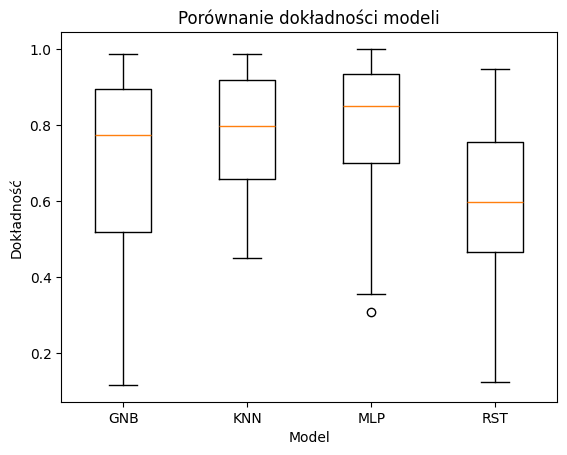

In [4]:
accuracy_data = [results[:, :, i, 0].ravel() for i in range(len(clfs))]

fig, ax = plt.subplots()
ax.boxplot(accuracy_data, labels=['GNB', 'KNN', 'MLP', 'RST'])
ax.set_title('Porównanie dokładności modeli')
ax.set_ylabel('Dokładność')
ax.set_xlabel('Model')
plt.show()

In [5]:
results_df = pd.DataFrame(results.reshape(-1, 4), columns=['Accuracy', 'Recall', 'Precision', 'Classifier'])
results_df['Classifier'] = np.repeat(['GNB', 'KNN', 'MLP', 'RST'], len(results_df) / 4)
print(results_df)

     Accuracy    Recall  Precision Classifier
0    0.849057  0.849057   0.840766        GNB
1    0.867925  0.867925   0.864245        GNB
2    0.849057  0.849057   0.873208        GNB
3    0.867925  0.867925   0.860063        GNB
4    0.830189  0.830189   0.888673        GNB
..        ...       ...        ...        ...
715  0.407008  0.407008   0.175614        RST
716  0.219677  0.219677   0.363408        RST
717  0.537736  0.537736   0.536004        RST
718  0.576819  0.576819   0.574535        RST
719  0.407008  0.407008   0.174893        RST

[720 rows x 4 columns]


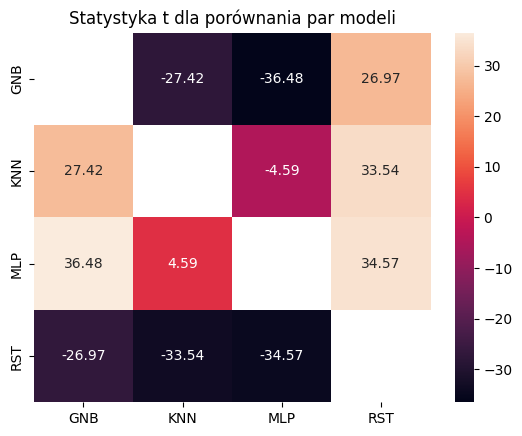

In [6]:
model_names = ['GNB', 'KNN', 'MLP', 'RST']

sns.heatmap(t_stat_matrix, annot=True, fmt=".2f", xticklabels=model_names, yticklabels=model_names)
plt.title('Statystyka t dla porównania par modeli')
plt.show()

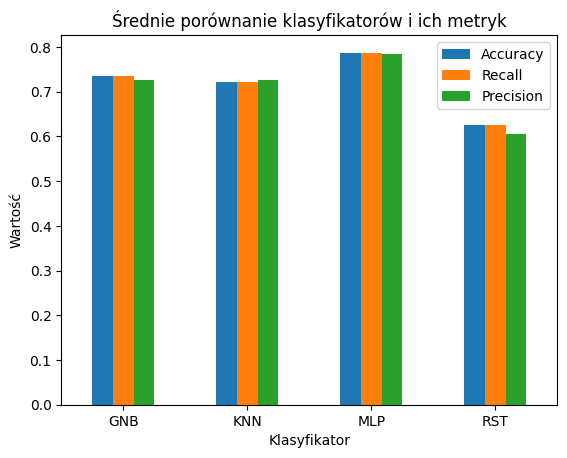

In [7]:
mean_metrics = results_df.groupby('Classifier').mean()
mean_metrics.plot(kind='bar', rot=0)
plt.title('Średnie porównanie klasyfikatorów i ich metryk')
plt.ylabel('Wartość')
plt.xlabel('Klasyfikator')
plt.show()